# 10. 여러 데이터 소스를 통합 데이터셋으로 합치기
- 원본 데이터를 읽어들이고 전처리하는 루틴 만들기
<img src="https://user-images.githubusercontent.com/107118671/190064763-631663bf-7191-4eb4-b7f3-b3f7d6c248e6.png" width='70%' height='70%' align='left'>

#### 원본 데이터를 훈련 샘플로 바꾸기 위해 필요한 작업

## 10.1 원본 CT 데이터 파일
- CT 데이터는 메타데이터 헤더 정보가 포함된 .mhd 파일과 3차원 배열을 만들 원본 데이터 바이트를 포함하는 .raw파일로 종류는 두 가지
- 각 파일 이름은 __시리즈 UID__ (DICOM, Digital Imaging and Communications in Medicine) 라고 불리는 CT 스캔 단일 식별자로 시작
- 예를 들어 시리즈 UID 1.2.3의 경우, 1.2.3.mhd와 1.2.3.raw의 두 가지 파일이 있음


#### Ct 클래스는 두 파일을 읽어서 3차원 배열을 만들고 환자 좌표계를 배열에서 필요로 하는 인덱스, 행, 열 좌표로 바꿔주는 변환 행렬도 만듦
#### LUNA에서 제공하는 에노테이션 데이터에는 각 결절의 좌표 목록, 악성 여부, 그리고 해당 CT 스캔의 시리즈 UID가 포함돼 있음
#### CT 데이터의 작은 3차원 부분 단면을 얻어 우리는 훈련 샘플 튜플의 나머지를 구성하는 것이 목적
#### 데이터를 제한하거나 잘라서 모델에 노이즈가 끼지 않게 하는 것도 중요 + 지나치게 걸러내어 중요 시그널을 잘려버리지 않게 해야함

## 10.2 애노테이션 데이터 파싱
- 좌표 정보, 해당 좌표 지점이 결절인지 여부, CT 스캔에 대한 고유 식별자를 얻을 것으로 기대
<img src="https://user-images.githubusercontent.com/107118671/190066361-d8a405f8-50fc-453b-abd6-c108d8d314d9.png" width='70%' height='70%' align='left'>

- candidates에는 조직 덩어리 전체가 들어있음 / annotations에는 결절로 플래그된 후보들에 대한 정보가 들어있음

- annotations에는 크기에 대한 정보도 들어있음

In [1]:
# 쉘 스크립트에서

# wc -l candidates.csv

SyntaxError: invalid syntax (3112287262.py, line 2)

In [ ]:
# head candidates.csv 

# 파일 앞부분 일부를 출력, 첫 줄은 칼럼 헤더

In [ ]:
# grep ',1$' candidates.csv | wc -l 

# 결절이라서 1로 끝나는 행 개수 카운트

#### 전체 행 개수는 551000이며 각각은 seriesuid  와 x,y,z 좌표, 그리고 결절 상태를 의미하는 class 열로 구성

In [ ]:
# wc -l annotations.csv

# 출력된 숫자가 1187로 candidates.csv과 다름

In [ ]:
# head annotations.csv


# seriesuid,coordX,coordY,coordZ,diameter_mm
# 마지막 열 정보도 다름

### 10.2.1 훈련셋과 검증셋
- 크기 순으로 정렬한 후 매 N 번째에 대해 검증셋에 넣어서 분포를 반영한 검증셋 구성할 것임
- 그러나 annotations.csv에서 제공하는 위치 정보는 candidates.csv 좌표와 정확히 일치하지 않음

### 10.2.2 애노테이션 데이터와 후보 데이터 합치기

In [ ]:
# import copy
# import csv
# import functools
# import glob
# import os

# from collections import namedtuple

# import SimpleITK as sitk
# import numpy as np

# import torch
# import torch.cuda
# from torch.utils.data import Dataset

# from util.disk import getCache
# from util.util import XyzTuple, xyz2irc
# from util.logconf import logging

# log = logging.getLogger(__name__)
# # log.setLevel(logging.WARN)
# # log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

# raw_cache = getCache('part2ch10_raw')

In [ ]:
# CandidateInfoTuple = namedtuple(
#     'CandidateInfoTuple',
#     'isNodule_bool, diameter_mm, series_uid, center_xyz',
# )

# 결절의 상태(1 or 0), 결절의 직경, 순번, 중심점 순

In [2]:
# @functools.lru_cache(1) # 표준 인메모리 캐싱 라이브러리
# def getCandidateInfoList(requireOnDisk_bool=True): # 디스크에 없는 데이터는 걸러내기 위함
#     mhd_list = glob.glob('data-unversioned/subset*/*.mhd')
#     # glob.blob() 은 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
#     presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}
#     # os.path.split(filename) : 디렉토리와 파일을 분리하여 리스트로 나타낸다
    
#     # annotations.csv의 직경 정보 합치기
#     diameter_dict = {}
#     with open('../data/part2/luna/annotations.csv', "r") as f:
#         for row in list(csv.reader(f))[1:]:
#             series_uid = row[0]
#             annotationsCenter_xyz = tuple([float(x) for x in row[1:4]])
#             annotationDiameter_mm = float(row[4])

#             diameter_dict.setdefault(series_uid,[]).append(
#                 (annotationsCenter_xyz, annotationDiameter_mm)
#             )
            
#     # candidates.csv의 정보를 사용하여 전체 후보 리스트 만들기
#     candidateInfo_list = []
#     with open('../data/part2/luna/candidates.csv', "r") as f:
#         for row in list(csv.reader(f))[1:]:
#             series_uid = row[0]

#             if series_uid not in presentOnDisk_set and requireOnDisk_bool: 
#             # series_uid가 없으면 서브셋에 있지만 디스크에는 없으므로 건너뜀
#                 continue

#             isNodule_bool = bool(int(row[4]))
#             candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

#             candidateDiameter_mm = 0.0
#             for annotation_tup in diameter_dict.get(series_uid, []):
#                 # diameter_dict.get(series_uid, [])
#                 annotationCenter_xyz, annotationDiameter_mm = annotation_tup
#                 for i in range(3):
#                     delta_mm = abs(candidateCenter_xyz[i] - annotationCenter_xyz[i])
#                     if delta_mm > annotationDiameter_mm / 4: 
#                     # 반경을 얻기 위해 직경을 2로 나누고 두 개의 결절 센터가 결절의 크기 기준으로 너무 떨어져 있는 지를 
#                     # 반지름의 절반 길이 기준으로 판정
#                         break
#                     else:
#                         cadidateDiameter_mm = annotationDiameter_mm
#                         break

#                 candidateInfo_list.append(CandidateInfoTuple(isNodule_bool, candidateDiameter_mm, series_uid, candidateCenter_xyz,))
    
#     candidateInfo_list.sort(reverse=True) # 모든 결절 샘플을 내림차순으로 정렬했고 그 뒤에는 (크기정보 없는) 결절이 아닌 샘플이 이어짐
#     return candidateInfo_list

# getCandidateInfoList(requireOnDisk_bool=True)

NameError: name 'functools' is not defined

- noduleInfo_list의 튜플 멤버 순서는 이 정렬로 만들어짐
- 이렇게 데이터를 정렬 시 일부 CT 단면들을 모아 결절 직경에 대해 잘 분포된 실제 결절을 반영하는 덩어리 얻을 수 있음

## 10.3 개별 CT 스캔 로딩
- 디스크에서 CT 데이터를 얻어와 파이썬 객체로 변환
### 10.3.1 하운스필드 단위
- 공기는 -1000HU, 물은 0HU, 뼈는 +1000HU

## 10.4 환자 좌표계를 사용해 결절 위치 정하기
### 10.4.1 환자 좌표계
- 밀리미터 기반 좌표계인 (X,Y,Z)로부터 CT 스캔 단 면 데이터 배열에서 사용한 복셀 주소 기반 좌표계인 (I,R,C)로 좌표 변환 필요
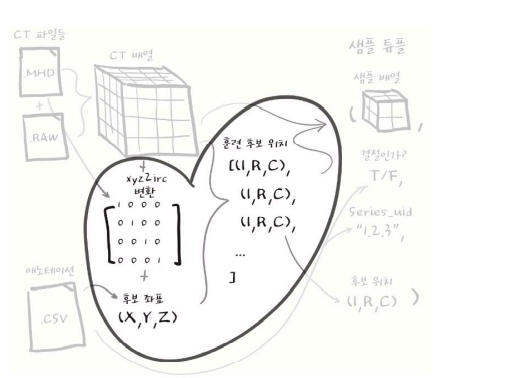

### 10.4.2 CT 스캔 형태와 복셀 크기
- 복셀은 정육면체가 아니기 때문에 왜곡 있음. 비율 계수(scale factor)를 적용해야 함
- CT는 일반적으로 512행 512열로 구성되며 인덱스 차원은 대략 100-250개의 단면으로 이루어짐
- 이는 약 2**25개의 복셀에 해당되며 3200만 개의 데이터 포인트임

### 10.4.3 밀리미터를 복셀 주소로 변환하기
- 환자의 밀리미터 좌표(xyz)와 (irc)배열좌표 변환을 돕기 위한 유틸리티 코드 정의

In [ ]:
# util.py:16 코드
# IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
# XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])

# def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
#     cri_a = np.array(coord_irc)[::-1]
#     origin_a = np.array(origin_xyz)
#     vxSize_a = np.array(vxSize_xyz)
#     coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
#     # coords_xyz = (direction_a @ (idx * vxSize_a)) + origin_a
#     return XyzTuple(*coords_xyz)

# def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
#     origin_a = np.array(origin_xyz)
#     vxSize_a = np.array(vxSize_xyz)
#     coord_a = np.array(coord_xyz)
#     cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
#     cri_a = np.round(cri_a)
#     return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))

### 10.4.4 CT 스캔에서 결절 추출하기
- 각 후보 영역을 추출해 모델이 한 번에 한 영역에 집중할 수 있도록 만들 예정
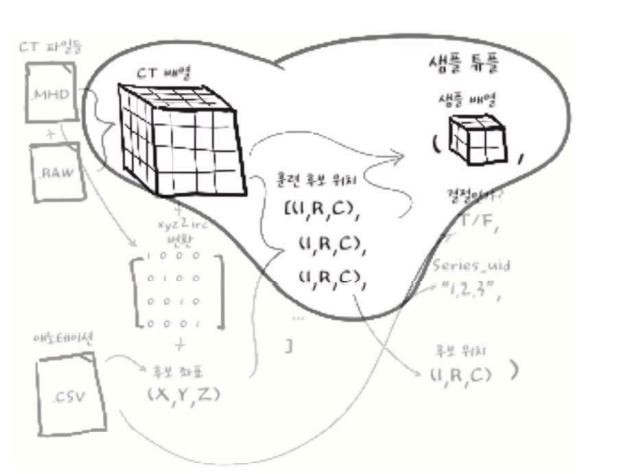

In [ ]:
# dsets.py:105. CT.getRawCandidate
#     def getRawCandidate(self, center_xyz, width_irc):
#         center_irc = xyz2irc(
#             center_xyz,
#             self.origin_xyz,
#             self.vxSize_xyz,
#             self.direction_a,
#         )

#         slice_list = []
#         for axis, center_val in enumerate(center_irc):
#             start_ndx = int(round(center_val - width_irc[axis]/2))
#             end_ndx = int(start_ndx + width_irc[axis])

#             assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr(
#                 [self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

#             if start_ndx < 0:
#                 # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
#                 #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
#                 start_ndx = 0
#                 end_ndx = int(width_irc[axis])

#             if end_ndx > self.hu_a.shape[axis]:
#                 # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
#                 #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
#                 end_ndx = self.hu_a.shape[axis]
#                 start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

#             slice_list.append(slice(start_ndx, end_ndx))

#         ct_chunk = self.hu_a[tuple(slice_list)]

#         return ct_chunk, center_irc

## 10.5 간단한 데이터셋 구현
- LunaDataset 클래스 만들어 샘플을 정규화하고, 각 CT의 결절을 평탄화 작업을 통해 인출하기 쉽도록 만듦

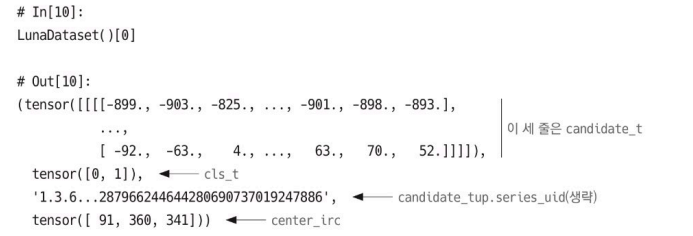  
<br> getitem이 네 개의 아이템을 반환하는데 각각 candidate_t / cls_t / candidate_tup.series_uid / center_irc 임

### 10.5.1 getCtRawCandidate 함수로 후보 배열 캐싱하기
- LunaDataset으로부터 쓸만한 성능을 얻으려면 온디스크 캐싱(on-disk caching)에 시간 들일 필요 있음
- 모든 샘플에 대해 디스크로부터 전체 CT 스캔을 읽는 부담을 피할 수 있음

In [ ]:
# dsets.py:162, LunaDataset.__init__

# @functools.lru_cache(1, typed=True)
# def getCt(series_uid):
#     return Ct(series_uid)


# @raw_cache.memoize(typed=True)
# def getCtRawCandidate(series_uid, center_xyz, width_irc):
#     ct = getCt(series_uid)
#     ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc) 
#     return ct_chunk, center_irc

getCt의 반환값을 메모리에 캐싱해서 동일한 Ct 인스턴스에 대한 요청은 디스크에서 모든 데이터를 다시 읽을 필요가 없도록 대응  

지금 알아두어야 할 것 :  
디스크에서 2^15개의 float32 값을 읽는 것이 2^25개의 int16 값을 읽고 float32로 변환한 후 2^15개의 서브셋을 선택하는 것보다 빠르다는 것

### 10.5.2 LunaDataset._init_으로 데이터셋 만들기
- 샘플 중에 10번째에 해당하는 모든 경우를 검증셋으로 둠

In [ ]:
# dsets.py:149

# class LunaDataset(Dataset):
#     def __init__(self,
#                  val_stride=0,
#                  isValSet_bool=None,
#                  series_uid=None,
#                  ):
#         self.candidateInfo_list = copy.copy(getCandidateInfoList())
            # 반환되는 값을 복사해서 self.candidatesInfo_list 변경에 영향받지 않도록 캐시

#         if series_uid:
#             self.candidateInfo_list = [
#                 x for x in self.candidateInfo_list if x.series_uid == series_uid
#             ]

### 10.5.3 훈련/검증 분리

In [ ]:
#         if isValSet_bool:
#             assert val_stride > 0, val_stride
#             self.candidateInfo_list = self.candidateInfo_list[::val_stride]
#             assert self.candidateInfo_list
#         elif val_stride > 0:
#             del self.candidateInfo_list[::val_stride] # 검증용 이미지 삭제 (미리 복사한 값이므로 원래 리스트는 삭제 x)
#             assert self.candidateInfo_list

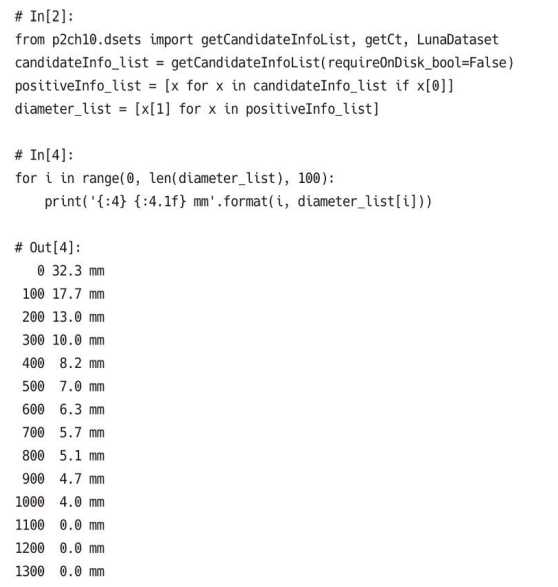

### 10.5.4 데이터 렌더링

In [1]:
# p2ch10_explore_data.ipynb